In [4]:
import pandas as pd
import igraph as ig
from ease import EASE
import seaborn as sns
import numpy as np
import pickle
import multiprocessing

path = './files/'

In [3]:
# load gene set dictionaries - msigdb
def open_pickle(file):
    with open(path+file, 'rb') as pickle_file:
        return pickle.load(file=pickle_file)
    
msigdb_c6_dict = open_pickle('msigdb_c6_all_dict.pkl')
misgdb_c2_cgp_dict = open_pickle('msigdb_c2_cgp_dict.pkl')
misgdb_c3_tft_dict = open_pickle('msigdb_c3_tft_dict.pkl')


In [5]:
# get network data from pickle  
regulome_network_edges = pd.read_csv(filepath_or_buffer='./files/human_regulome_pd.gz', compression='infer')
regulome_network_edges = regulome_network_edges.astype({'ProteinAid': 'str', 'ProteinBid':'str'})

regulome_network_graph = ig.Graph.DataFrame(regulome_network_edges, directed=True, use_vids = False)
regulome_network_graph_undirected = ig.Graph.DataFrame(regulome_network_edges, directed=False, use_vids = False)

In [6]:
# Investigate Leiden resolution
std_output = pd.DataFrame({
    'pathway_id': ['---'],
    'Overlap': [0],
    'Pvalue': [1],
    'FDR': [1],
    'FWER': [1] 
})
cov = 4000 # what should I set this to??

def cluster_leiden(graph, res, b=0.01, n_iter=3):
    return graph.community_leiden(objective_function='modularity',
                                weights='PPV',
                                resolution=res,
                                beta=b,
                                n_iterations=n_iter) # only few small clusters and 1 large one

def cluster_louvain(graph, res):
    return graph.community_multilevel(weights='PPV',
                                    return_levels=False,
                                    resolution=res)


cluster_enrichment_dict = dict() # output is a dictionary (resolution) of tuple with dictionary (per cluster) containing tuple with a pandas df (containing enrichment fr each pathway)

def set_enrichment(res):
    print(f"Reslution: {res}")
    clusters = cluster_leiden(regulome_network_graph_undirected, res=res, b=0.05)

    enrichment_dict = dict()
    for (cluster_n, cluster) in enumerate(clusters.subgraphs()):
        query = cluster.vs['name']
        if (len(query) > 750) or (len(query) < 3):
            continue
        enrichment = EASE(query_set=query, genesets=misgdb_c3_tft_dict, PT=cov)
        enrichment_dict[cluster_n] = (enrichment, len(query), query) # maybe save this as a namedtuple with enrihcment and subgraph
    return res, enrichment_dict, len(enrichment_dict)

def collect_enrichment(enrichment):
 # pool returns values in a list, therefore Have tuple in a list and have to extract
    cluster_enrichment_dict[enrichment[0]] = enrichment[1:]


res_range = np.arange(3, 6, 1)
num_processes = 4

# collect_enrichment(set_enrichment(2))
with multiprocessing.Pool(num_processes) as pool:
    pool = multiprocessing.Pool(num_processes)
    for res in res_range:
        pool.apply_async(func=set_enrichment, args=(res,), callback=collect_enrichment)
    pool.close()
    pool.join()

Reslution: 3Reslution: 4Reslution: 5




In [ ]:
# save to pickle
# with open(path+'clustering_results/misgdb_c2_leiden_1_10_1_b005.pkl', 'wb') as file:
#     pickle.dump(cluster_enrichment_dict, file=file)

In [ ]:
distributions_df = pd.DataFrame()
for (res, cluster_enrichments) in cluster_enrichment_dict.items():
    n_clusters = cluster_enrichments[1]
    cluster_sizes = [cluster[1] for cluster in cluster_enrichments[0].values()]
    distributions_df = pd.concat([distributions_df, pd.DataFrame({'size': cluster_sizes, 'resolution':[res]*n_clusters})])

In [ ]:
distributions_df

In [ ]:
fig = sns.FacetGrid(distributions_df[distributions_df.resolution != 9], col='resolution', col_wrap=4)
fig.map(sns.histplot, 'size')
fig.fig.suptitle("Size distributions of Leiden clusters at different resolutions")
fig.fig.subplots_adjust(top=0.9)
fig.savefig('./images/leiden_msigdbc3_1_10_005.png')

In [ ]:
set_sizes = [len(gene_set) for gene_set in misgdb_c2_cgp_dict.values()] 
print(min(set_sizes))
fig = sns.histplot(set_sizes, binwidth=5)
fig.set_title("Size distribution of MSigDB disease gene sets")
fig.set_xlim([0,500])
fig.get_figure().savefig("helloo.png")

In [ ]:
CCS_dict = dict()
threshold = 0.01

for (res, cluster_enrichments) in cluster_enrichment_dict.items():
    enriched_list = list()
    enrichment_dict = cluster_enrichments[0]
    n_clusters = 0
    # n_clusters = cluster_enrichments[1] # number of appropriately sized clusters, filtered before EASE
    for _, enrichment in enrichment_dict.items():
        enrichment = enrichment[0]
        enriched = enrichment[enrichment.FDR < threshold]
        if len(enriched) != 0:
            enriched_list.append(enriched)
            n_clusters += 1

    if len(enriched_list) == 0:
        CCS_dict[res] = (pd.DataFrame({'pathway_id': [],
                                                'Overlap': [],
                                                'Pvalue': [],
                                                'FDR': [],
                                                'FWER': []}), 0)
        continue
    
    enriched_df = pd.concat(enriched_list)
    n_enriched_pathways = len(pd.unique(enriched_df['pathway_id']))
    cluster_per_path = enriched_df.groupby('pathway_id')['pathway_id'].count().mean()
    # print(n_enriched_pathways)
    # CCS = n_enriched_pathways/(cluster_per_path*n_enriched_pathways)
    # print(pathway_per_cluster)

    # CCS_dict[res] = (enriched_df, CCS)

1.0
1.0638297872340425
1.0461538461538462


<Axes: >

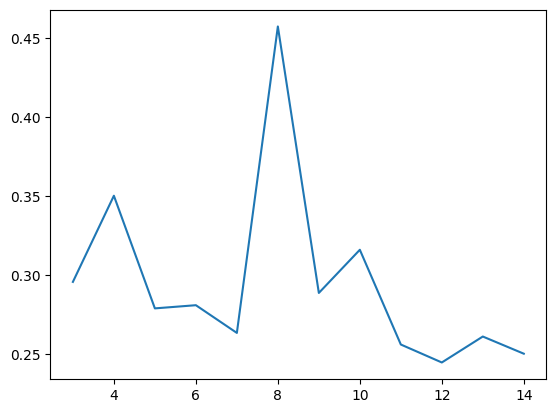

In [114]:
CCS_list = [CCS[1] for CCS in CCS_dict.values()]
resolutions = CCS_dict.keys()

sns.lineplot(x=resolutions, y=CCS_list)

In [ ]:
num_pathways = list()
for res, hits in CCS_dict.items():
    num_pathways.append(len(hits[0].pathway_id.unique()))
num_pathways
 
plot = sns.lineplot(x=resolutions, y=num_pathways)
plot.set_title("Number of enriched pathwys per resolution in Louvain")
plot.set_xlim([0,10])


In [ ]:
n_clusters = [n[1] for n in cluster_enrichments.values()]

sns.lineplot(x=n_clusters, y=num_pathways)

In [ ]:
infomap_clusters = regulome_network_graph.community_infomap(edge_weights='5:PPV', trials=10) # generaetd some small clusters and 1 large one

In [ ]:


leiden_clusters = regulome_network_graph_undirected.community_leiden(objective_function='modularity',
                                                          weights='5:PPV',
                                                          resolution=12.0,
                                                          beta=0.01,
                                                          n_iterations=3) # only few small clusters and 1 large one

In [ ]:
# non-overlapping   

louvain_clusters = regulome_network_graph_undirected.community_multilevel(weights='PPV',
                                                                          return_levels=False,
                                                                          resolution=5)